# HEALTHCARE

### ENTENDER EL ENUNCIADO DEL PROBLEMA Y EL CASO PRACTICO

* Laa inteligencia artificial esta revolucionando la atencion sanitarias en muchas areas como:
    * Diagnostico de enfermedades con imagenes medicas
    * Robots quirurgicos
    * Maximizacion de la eficiencia hospitalaria

* Se espera que el mercado de la salud de la IA alcance los $45,2 mil millones de dolares para 2026 a partir de la valoracion actual de $4,9 mil millones de dolares

* Se ha demostrado que el aprendizaje profundo es superior en la deteccion de enfermedades a partir de rayox X, resonancias magneticas y tomografias computarizadas, lo que podria mejorar significativamente la velocidad y precision del diagnostico

* En este caso de estudio, asumiremos que usted trabaja como consultor de IA / ML y ha sido contratado por una empresa de diagnostico medico de New York

* Se le ha encomendado la tarea de mejorar la velocidad y la precision de la deteccion y localizacion de tumores cerebrales en funcion de las imagenes por resonancia magnetica. Esto reducira drasticamente el coste del diagnostico de cancer y ayudaria en el diagnostico temprano de tumores, lo que esencialmente salvaria la vida

* El equipo ha recopilado imagenes por resonancia magnetica del cerebro y se ha acercado a nosotros para desarrollar un modelo que pueda detectar y localizar tumores. Se nos ha proporcionado 3929 resonancias magneticas cerebrales junto con la ubicacion del tumor cerebral

#### QUE ES LA SEGMENTACION DE IMAGENES?
* El objetivo de la segmentacion de imagenes es comprender y extraer la informacion de las imagenes a nivel de pixel

* La segmentacion de imagenes se puede utilizar para el reconocimiento y la localizacion de objetos, lo que ofrece un valor tremente en muchas aplicaciones como imagenes medicas y automoviles autonomos, etc

* El objetivo de la segmentacion de imagenes es entrenar una red neuronal para producir una mascara de pixeles de la imagen

* Las tecnicas modernas de segmentacion de imagenes se basan en un enfoque de aprendizaje profundo que hace uso de arquitecturas comunes como RNC, RCT (Redes de convolucion total) y codificadores-decodificadores profundos

* Utilizamos la arquitectura ResUNet para resolver la tarea actual

* Recuerdas cuando aplicamos RNC para problemas de clasificacion de imagenes? Tuvimos que convertir la imagen en un vector y posiblemente agregar un encabezado de clasificacion al final. Sin embargo en el caso de la Unet convertimos (codificamos) la imagen en un vector seguido de un muestreo ascendente (decodificamos) de nuevo en una imagen

* En el caso de la Unet, la entrada y la salida tienen el mismo tamaño por lo que se conserva el tamaño de la imagen

* `Para RNC clasicas: ` generalmente se utilizan cuando se necesita clasificar la imagen completa como una etiqueta de clase

* `Para Unet: ` se realizan una clasificacion a nivel de pixel. Unet formula una funcion de perdida para cada pixel de la imagen de entrada

* La funcion Softmax se aplica a cada pixel, lo que hace que el problema de segmentacion funcione como un problema de clasificacion donde la clasificacion se realiza en cada pixel de la imagen


### LIBRERIAS

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
%matplotlib inline

### DATASET

In [5]:
path_data = "../dataset/Healthcare/Brain_MRI/"

In [6]:
brain_df = pd.read_csv(path_data + "data_mask.csv")
brain_df.head()

patient_id                                         image_path  \
0  TCGA_CS_5395_19981004  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1  TCGA_CS_5395_19981004  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2  TCGA_CS_5395_19981004  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3  TCGA_CS_5395_19981004  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4  TCGA_CS_5395_19981004  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   

                                           mask_path  mask  
0  TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1  TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2  TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3  TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4  TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0

#### MASCARAS

* El objetivo de la segmemtacion de imagenes es comprender la imagen a nivel de pixel, Asocia cada pixel con una determinada clase. La salida producida por el modelo de segmentacion de imagenes se denomica `mascara` de la imagen

* Las `mascaras` se pueden representar asociando valroes de pixeles con sus coordenadas

In [7]:
brain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [10]:
# Path de la imagen de MRI
print(brain_df['mask_path'][0]) 
# Path de la mascara de segmentacion
print(brain_df['image_path'][0])

TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_mask.tif
TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif


### TAREA 1
* Tenemos un dataset balanceado?
* Cuantas muestras estan marcadas como paciente sano?

In [11]:
brain_df['mask'].value_counts()

0    2556
1    1373
Name: mask, dtype: int64

Se considera un dataset un poco desbalanceado ya que la proporcion de imagenes que no tienen tumor es del doble de las que si tienen tumor

Hay 2556 muestras marcadas como pacientes sano

### VISUALIZACION DE LOS DATOS

In [14]:
brain_df

patient_id  \
0     TCGA_CS_5395_19981004   
1     TCGA_CS_5395_19981004   
2     TCGA_CS_5395_19981004   
3     TCGA_CS_5395_19981004   
4     TCGA_CS_5395_19981004   
...                     ...   
3924  TCGA_DU_6401_19831001   
3925  TCGA_DU_6401_19831001   
3926  TCGA_DU_6401_19831001   
3927  TCGA_DU_6401_19831001   
3928  TCGA_DU_6401_19831001   

                                             image_path  \
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif   
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif   
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif   
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif   
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif   
...                                                 ...   
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...   
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...   
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...   
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...   
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...   

                                              mask_path  mask  
0     TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...     0  
1     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...     0  
2     TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...     0  
3     TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...     0  
4     TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...     0  
...                                                 ...   ...  
3924  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...     0  
3925  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...     0  
3926  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...     0  
3927  TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...     0  
3928  TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...     0  

[3929 rows x 4 columns]

In [15]:
brain_df['mask'].value_counts().index

Int64Index([0, 1], dtype='int64')

In [20]:
# Usaremos plotly para hacer un diagrama de baras interactivo
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index,
    y = brain_df['mask'].value_counts())])

fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
    marker_line_width = 7, opacity = 0.6)

fig.show()

In [21]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [30]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

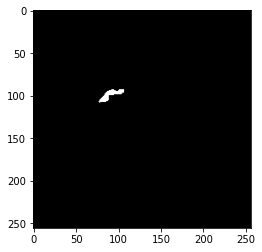

In [36]:
plt.imshow(cv2.imread(path_data + brain_df.mask_path[623]))

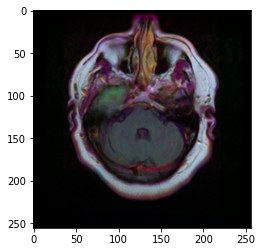

In [37]:
plt.imshow(cv2.imread(path_data + brain_df.image_path[623]))

In [38]:
cv2.imread(path_data + brain_df.mask_path[623]).max()

255

In [39]:
cv2.imread(path_data + brain_df.mask_path[623]).min()

0

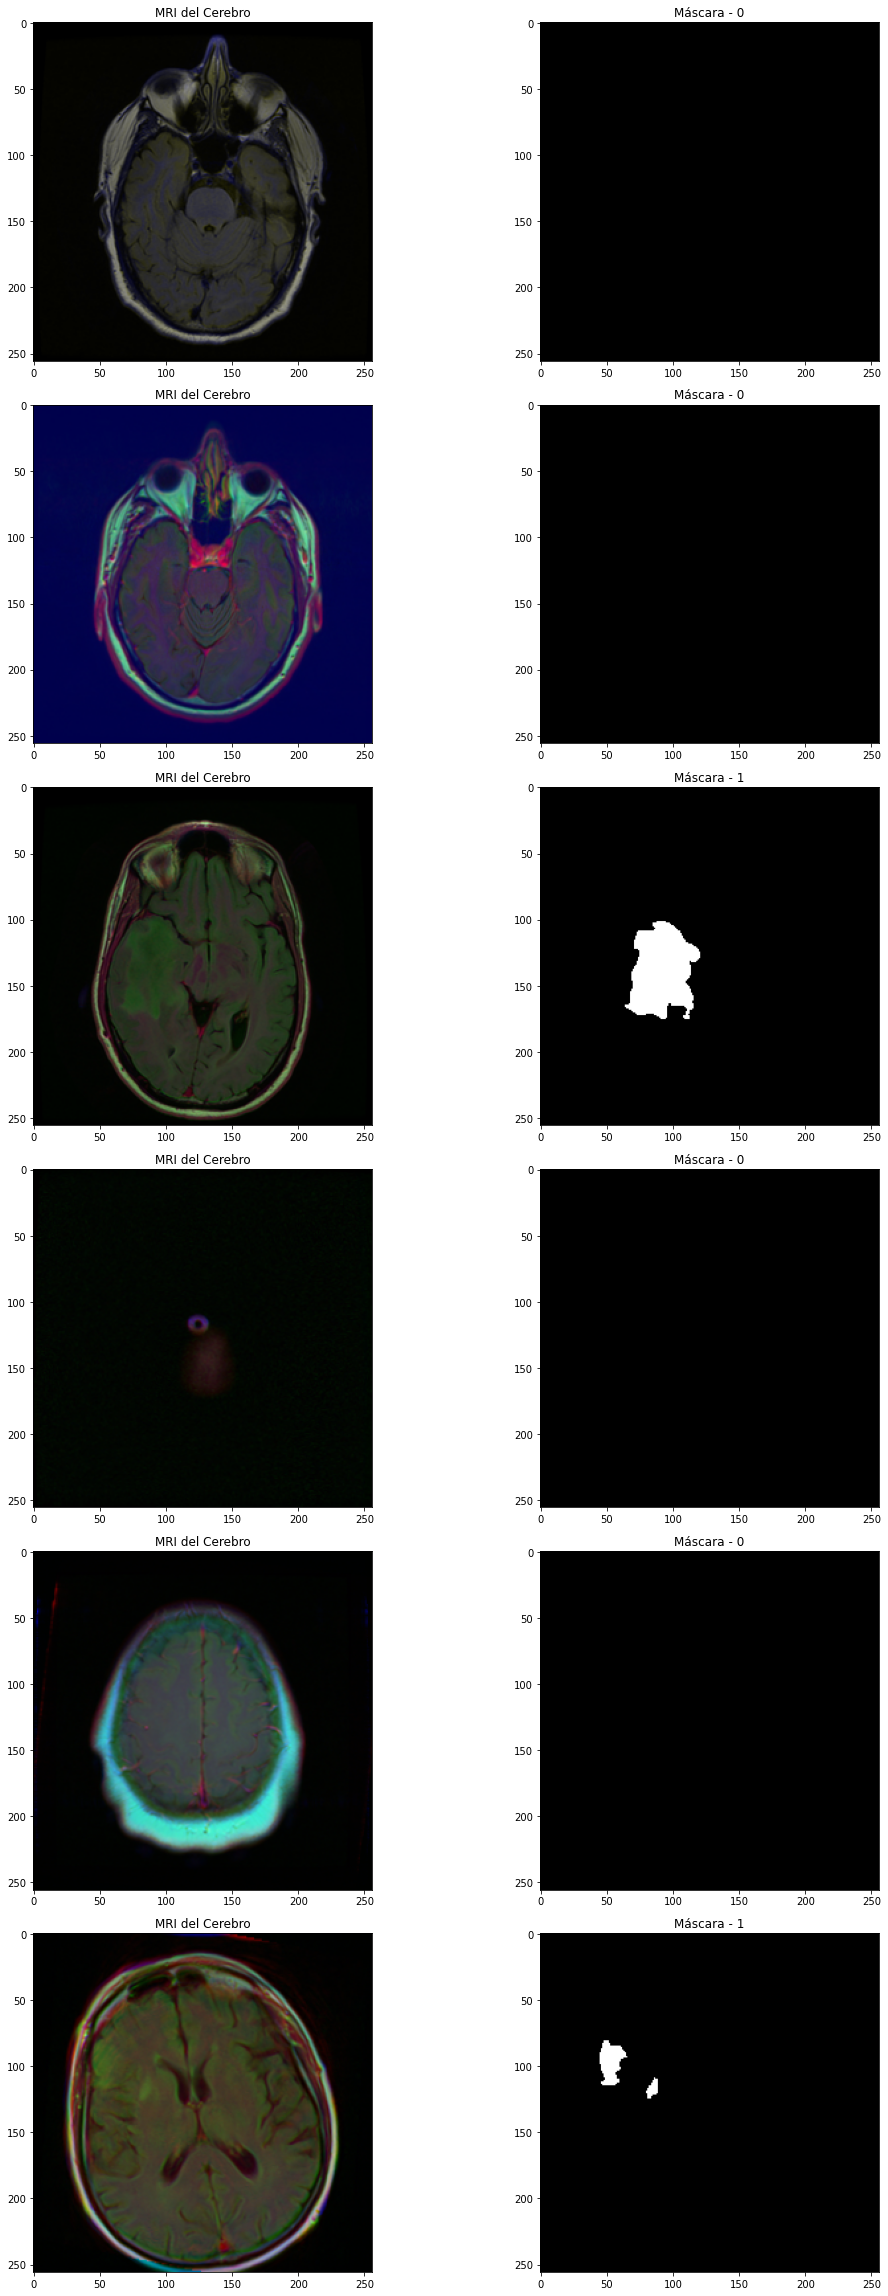

In [42]:
# Visualizacion basica, visualizaremos imagenes (MRI y Mascaras)
# en el dataset de forma separada
import random

fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
    i = random.randint(0, len(brain_df)) # Seleccionamos un índice aleatorio
    axs[count][0].title.set_text("MRI del Cerebro") # Configuramos el título
    axs[count][0].imshow(cv2.imread(path_data + brain_df.image_path[i])) # Mostramos la MRI 
    axs[count][1].title.set_text("Máscara - " + str(brain_df['mask'][i])) # Colocámos el título en la máscara (0 o 1)
    axs[count][1].imshow(cv2.imread(path_data + brain_df.mask_path[i])) # Mostramos la máscara correspondiente 
    count += 1

fig.tight_layout()

### TAREA 2 
* Representar aleatoriamente 12 (1) imagenes de MRI seleccionadas aleatoriamente entre los pacientes enfermos seguidas de (2) su correspondiente mascara, (3) tanto la imagen de la MRI, junto con su mascara, (de color rojo) una encima de la otra

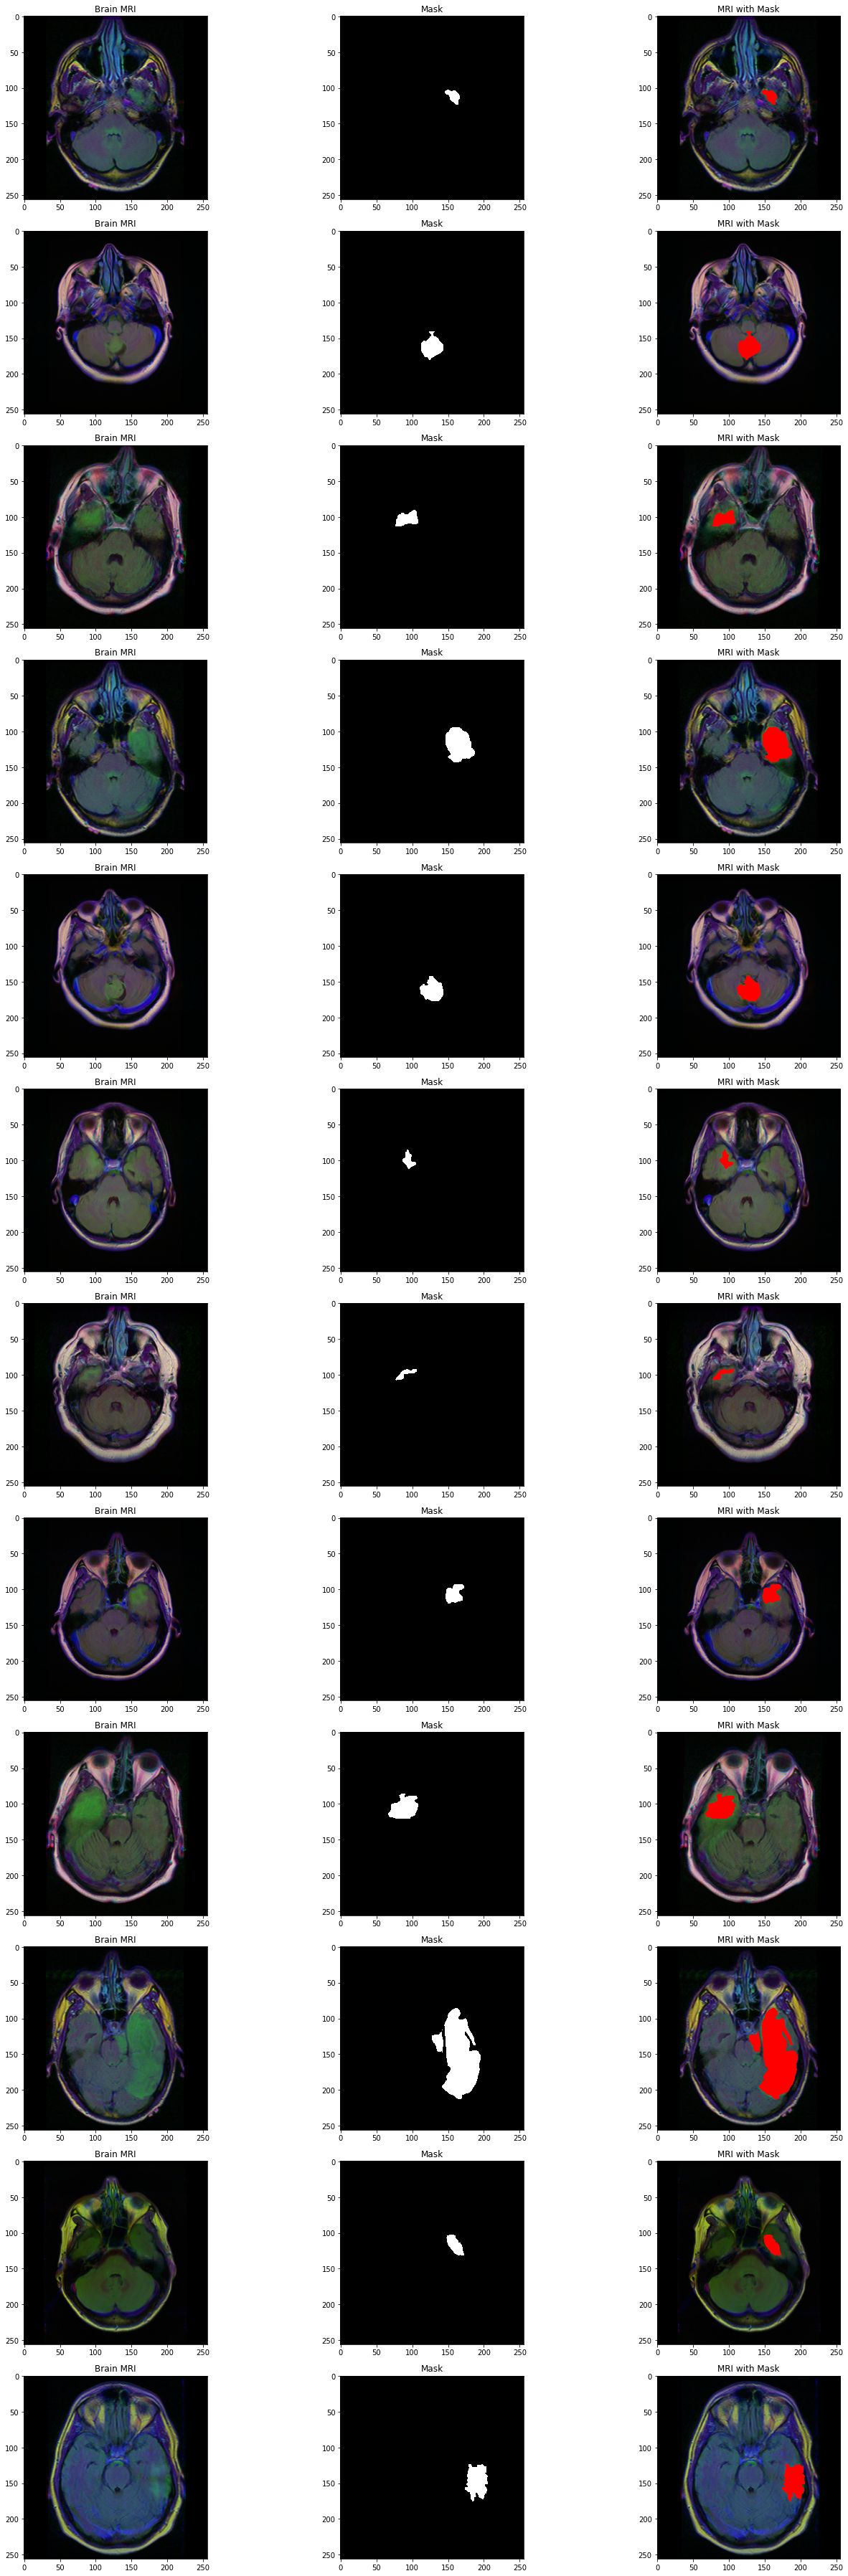

In [46]:
# Visualización avanzada: visualiza las imágenes por resonancia magnética 
# junto con su máscara en una imagen
count = 0 
fig, axs = plt.subplots(12, 3, figsize=(20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # Leemos las imágenes 
    img = io.imread(path_data + brain_df.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtenemos la máscara para la imagen
    mask = io.imread(path_data + brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')
    
    # Reemplazamos los valores en la imagen con color rojo (255,0,0) 
    # si algún píxel de máscara en la máscara era = 255
    img[mask == 255] = (255,0,0)    
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

### ENTENDER LA INTUICION DETRAS DE LAS RESNET Y LAS RNC

#### REDES NEURONALES CONVOLUCIONALES

* Las primeras capas de CNN se utilizan para extraer caracteristicas generales de alto nivel
* El ultimo par de capas se utilizan para realizar la clasificacion(en una tarea especifica)
* Los campos respectivos locales escanean la imagen primero en busca de formas simples como bordes / lineas
* Estos bordes son luego recogidos por la capa posterior para formar entidades mas complejas

#### RESNET (REDES RESIDUALES)

* A medida que las redes neuronales convolucionales (RNC) se hacen mas profundas, tienden a ocurrir el desvanecimiento del gradiente que impacta negativamente en el rendimiento de la red
* El problema del desvanecimiento del gradiente ocurre cuando el gradiente se propaga hacia atras a capas anteriores, lo que da como resultado un gradiente muy pequeño
* La red neuronal residual incluye la funcion de "omision sin conexion" que permite el entrenamiento de 152 capas sin el problema del desvanecimiento del gradiente
* ResNet funciona agregando "asignaciones de identidad" en la parte superior de la RNC
* ImageNet contiene 11 millones de imagenes y 11.000 categorias
* ImageNet se utiliza para entrenar la red profunda de ResNet


### TRANSFERENCIA POR APRENDIZAJE (TRANSFERS LEARNING)

 * El aprendizaje por transferencia es una tecnica de aprendizaje automatico en la que una red que ha sido entrenada para realizar una tarea especifica se reutiliza como punto de partida para otra tarea similar.

 * El aprendizaje por transferencia se usa ampliamente ya que partir de modelos previamente entrenados puede reducir drasticamente el tiempo de calculo requerido si el entrenamiento se realiza desde cero.

 #### TRANSFERIR ESTRATEGIAS DE ENTRENAMIENTO APRENDIZAJE

* Pasos de la estrategia nro 1:
    * Congelar los pesos de la red RNC entrenada de las primeras capas
    * Entrenar solo las capas densas recien agregadas (con pesos inicializados aleatoriamente)

* Pasos de la estrategia nro 2:
    * Inicializar la red de RNC con los pesos previamentes entrenados
    * Volvemos a entrenar toda la RNC mientras establece la tasa de aprendizaje para que sea muy pequeña, esto es fundamental para garantizar que no cambie agresivamente los pesos entrenados

* Las ventajas del aprendizaje por transferencia son:
    * Proporciona un progreso de entrenamiento rapido, no tiene que empezar desde cero utilizando pesos inicializados aleatoriamente
    * Se puede utilizar un pequeño conjunto de datos de entrenamiento para lograr resultados increibles

* Lecturas adicionales:
    * Feature Extraction and Convolutions: https://setosa.io/ev/image-kernels/
    * CNN Visualization: https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html

### TAREA 4
* Enumere los desafios del aprendizaje por transferencia (se requiere investigacion externa)

### ENTRENAR UN MODELO DE CLASIFICACION PARA DETECTAR SI EXISTE UN TUMOR O NO

In [47]:
# Eliminamos la columna de identificador del paciente
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [48]:
# Convertir los datos en la columna de mascara a formato string,
# para usar el modo categorico en flow_from_dataframe
# Veras este mensaje de error si comentad la siguiente linea de codigo:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x:str(x))
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [49]:
# Dividir los datos en entrenamiento y testing
from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [50]:
# Creamos el generador de imagenes
from keras_preprocessing.image import ImageDataGenerator

# Creamos un generador de datos que escale los datos de 0 a 1 y haga una
# division de validacion de 0,15
datagen = ImageDataGenerator(rescale = 1./255., validation_split = 0.15)

In [52]:
train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = path_data,
    x_col = 'image_path',
    y_col = 'mask',
    subset = "training",
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256, 256)
)

valid_generator = datagen.flow_from_dataframe(
    dataframe = train,
    directory = path_data,
    x_col = 'image_path',
    y_col = 'mask',
    subset = "validation",
    batch_size = 16,
    shuffle = True,
    class_mode = 'categorical',
    target_size = (256, 256)
)

# Creamos un generador de datos para imagenes de prueba
test_datagen = ImageDataGenerator(rescale = 1./255.)

test_generator = datagen.flow_from_dataframe(
    dataframe = test,
    directory = path_data,
    x_col = 'image_path',
    y_col = 'mask',
    batch_size = 16,
    shuffle = False,
    class_mode = 'categorical',
    target_size = (256, 256)
)

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


##### AQUI APLICAMOS EL APRENDIZAJE POR TRANSFERENCIA

In [55]:
# Obtenemos el modelo base de ResNet50
basemodel = ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_tensor = Input(shape = (256, 256, 3))
)

In [56]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [57]:
# Congelamos los pesos del modelo

for layer in basemodel.layers:
    layers.trainable = False
    

- 1 -> AveragePooling2D para bajar la imagen a un tamaño (4,4)
- 2 -> Aplanamiento de la informacion
- 3 -> Capa Densa de 256 units con funcion de activacion relu
- 4 -> Dropout se utiliza para mejorar la capacidad de generalizacion del modelo
- 5 -> Se aplica una segunda capa Densa
- 6 -> Se aplica otro dropout

In [58]:
# Agregamos una cabecera de clasificacion al modelo base

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4, 4))(headmodel) # 1
headmodel = Flatten(name = 'flatten')(headmodel)            # 2
headmodel = Dense(256, activation = 'relu')(headmodel)      # 3
headmodel = Dropout(0.3)(headmodel)                         # 4
headmodel = Dense(256, activation = 'relu')(headmodel)      # 5
headmodel = Dropout(0.3)(headmodel)                         # 6
#headmodel = Dense(256, activation = 'relu')(headmodel)     # 7
#headmodel = Dropout(0.3)(headmodel)                        # 8
headmodel = Dense(2, activation = 'softmax')(headmodel)     # 9

model = Model(inputs = basemodel.input, outputs = headmodel)

In [59]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [62]:
# Compilamos el modelo
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ["accuracy"]
)

In [64]:
# Utilizamos la parada temprana para salir del entrenamiento si la pérdida en la validación 
# no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el mejor modelo con la menor pérdida de validación
checkpointer = ModelCheckpoint(
    filepath="../models/healthcare/classifier-resnet-weights.hdf5", 
    verbose=1, save_best_only=True
)

In [66]:
history = model.fit(
    train_generator, 
    steps_per_epoch = train_generator.n // 16, 
    epochs = 15, 
    validation_data = valid_generator, 
    validation_steps = valid_generator.n // 16, 
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/15
177/177 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.6954
Epoch 1: val_loss improved from inf to 2.52214, saving model to ../models/healthcare/classifier-resnet-weights.hdf5
177/177 [==============================] - 670s 4s/step - loss: 0.6592 - accuracy: 0.6954 - val_loss: 2.5221 - val_accuracy: 0.6915
Epoch 2/15
177/177 [==============================] - ETA: 0s - loss: 0.4582 - accuracy: 0.7435
Epoch 2: val_loss improved from 2.52214 to 1.08365, saving model to ../models/healthcare/classifier-resnet-weights.hdf5
177/177 [==============================] - 662s 4s/step - loss: 0.4582 - accuracy: 0.7435 - val_loss: 1.0836 - val_accuracy: 0.6895
Epoch 3/15
177/177 [==============================] - ETA: 0s - loss: 0.4376 - accuracy: 0.7648
Epoch 3: val_loss did not improve from 1.08365
177/177 [==============================] - 827s 5s/step - loss: 0.4376 - accuracy: 0.7648 - val_loss: 3.5434 - val_accuracy: 0.6875
Epoch 4/15
177/177 [=============

In [67]:
# Guardamos la arquitectura del modelo en un archivo json para uso futuro
model_json = model.to_json()
with open("../models/healthcare/json/classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

### TAREA 5
* Cambia la arquitectura de la red agregando capas, neuronas, dropouts mas / menos densos
* Imprime el resumen del modelo y compara el numero total de parametros entrenables entre el modelo original y el nuevo

### EVALUAR LA EFICACIA DEL MODELO DE CLASIFICACION ENTRENADO

In [68]:
with open('../models/healthcare/json/classifier-resnet-model.json', 'r') as json_file:
    json_saveModel = json_file.read()

# Cargamos la arquitectura del modelo
model = tf.keras.models.model_from_json(json_saveModel)
model.load_weights('../models/healthcare/classifier-resnet-weights.hdf5')
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [69]:
# Hacemos la prediccion
test_predict = model.predict(
    test_generator, 
    steps = test_generator.n // 16, 
    verbose = 1
)

36/36 [==============================] - 24s 636ms/step


In [70]:
test_predict.shape

(576, 2)

In [71]:
test_predict

array([[0.9980394 , 0.00196055],
       [0.84276265, 0.15723735],
       [0.99515283, 0.0048471 ],
       ...,
       [0.77011865, 0.22988138],
       [0.97537994, 0.02462002],
       [0.99893576, 0.00106428]], dtype=float32)

In [75]:
# Obtenemos la clase predicha a partir del modelo
predict = []

for i in test_predict:
    predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

predict

array(['0', '0', '0', '0', '0', '1', '0', '1', '1', '0', '0', '1', '1',
       '0', '0', '1', '1', '0', '0', '1', '0', '1', '0', '0', '1', '0',
       '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0',
       '0', '0', '1', '0', '1', '1', '1', '0', '0', '0', '1', '0', '0',
       '0', '0', '1', '1', '1', '0', '1', '0', '1', '1', '1', '0', '0',
       '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '1',
       '1', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0',
       '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '1', '1', '0',
       '1', '1', '0', '0', '1', '1', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '1', '1', '1', '1', '1', '0', '0', '1', '0',
       '0', '0', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0',
       '0', '0', '0', '1', '1', '1', '0', '0', '0', '1', '0', '0', '1',
       '1', '0', '0', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '0', '1', '0', '0

In [76]:
# Dado que usamos el el generador de prueba, se limita
# el numero de imagen a predecir, debido al tamaño del lote
original = np.asarray(test['mask'])[:len(predict)]
len(original)

576

In [77]:
# Obtenemos la tasa de acierto del modelo
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

0.8506944444444444

<AxesSubplot:>

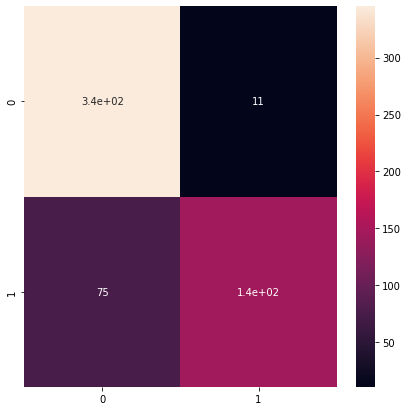

In [78]:
# Representamos la matriz de confuxion
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7, 7))
sns.heatmap(cm, annot = True)

### TAREA 6
* Imprime el informe de clasificacion y comenta sobre los resultados de precision, recuperacion y F1-Score

In [80]:
# Classification report
from sklearn.metrics import classification_report

print(classification_report(original, predict, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.82      0.97      0.89       356
           1       0.93      0.66      0.77       220

   micro avg       0.85      0.85      0.85       576
   macro avg       0.88      0.81      0.83       576
weighted avg       0.86      0.85      0.84       576



/Users/nahueltabasso/Documents/Deep-Learning/MasterClassDeepLearning/venv/lib/python3.8/site-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/nahueltabasso/Documents/Deep-Learning/MasterClassDeepLearning/venv/lib/python3.8/site-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/nahueltabasso/Documents/Deep-Learning/MasterClassDeepLearning/venv/lib/python3.8/site-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison

/Users/nahueltabasso/Documents/Deep-Learning/MasterClassDeepLearning/venv/lib/python3.8/site-packages/numpy/lib/arraysetops.py:608: FutureWarning:

elementwise comparison failed; returning scalar instead, but in the futu

### ENTENDER LA TEORIA Y LA INTUICION DETRAS DE LOS MODELOS RESUNET

#### RESUNET
* La arquitectura ResUNet combina la arquitectura de la red troncal UNet con bloques residuales para superar los problemas de desvanecimiento de gradientes en las arquitecturas profundas

* La arquitectura de Unet se basa en redes totalmente convolucionales y se modifica de manera que funcione bien en las tareas de segmentacion

* Resunet consta de 3 partes
    * 1 - Codificador o ruta de contratacion
    * 2 - Cuello de botella
    * 3 - Decodificador o ruta expansiva

#### ARQUITECTURA DE RESUNET

* `RUTA DE CONTRACCION (ENCODER): ` La ruta de contraccion consta de varios bloques de contraccion, cada bloque toma una entrada que pasa a traves de res-blocks seguido de una agrupacion maxima de 2x2. Los mapas de caracteristicas despues de cada bloque se duplican, lo que ayuda al modelo a aprender caracteristicas complejas de manera efectiva

* `CUELLO DE BOTELLA: ` El bloque cuello de botella sirve como conexion entre la ruta de contraccion y la ruta de expansion. El bloque toma la entrada y luego pasa a traves de un bloque res-seguido de un muestreo de capas de convolucion 2x2

* `CAMINO DE EXPANSION (DECODIFICADOR): ` La ventaja significativa de esta arquitectura radica en la seccion de expansion o decodificador. Cada bloque toma la entrada muestreada de la capa anterior y se concatena con las caracteristicas de salida correspondientes de los bloques res en la ruta de contraccion. Esto luego se pasa nuevamente a traves del bloque res seguido por capas de convolucion de muestreo ascendente 2x2. 
Esto ayuda a garantizar que las caracteristicas aprendidas durante la contraccion se utilicen al reconstruir la imagen. Finalmente, en la ultima capa de la ruta de expansion, la salida del bloque res pasa a traves de la capa de convolucion 1x1 para producir la salida deseada con el mismo tamaño que la entrada

* `1 - El codificador o ruta de contraccion consta de 4 bloques`:
    * El primer bloque consta de una capa de convolucion 3x3 + Relu + Normalizacion por lotes
    * Los tres bloques restantes constisten en bloques Res seguidos de un max pooling de tamaño 2x2 

* `2 - Cuello de botella`: 
    * Esta entre el camino de la contraccion y la expansion
    * Consiste en un bloque Res seguido de una capa convolucional de upsamplig de tamaño 2x2

* `3 - La ruta de expansion o decodificador consta de 4 bloques`: 
    * Los 3 bloques siguientes al cuello de botella consisten en bloques de Res seguidos por una capa convolucional de upsampling de tamaño 2x2
    * El bloque final consta de un Res-Block seguido de una capa de convolucion de 1x1


### CONSTRUIR UN MODELO DE SEGMENTACION PARA LOCALIZAR TUMORES CEREBRALES

In [117]:
# Obtenemos el dataframe que contiene las resonancias magneticas
# que tiene mascaras asociadas
brain_df_mask = brain_df[brain_df['mask'] ==1]
brain_df_mask.shape

(1373, 4)

In [118]:
# Dividir los datos en datos de prueba y de entrenamiento
from sklearn.model_selection import train_test_split

x_train, x_val = train_test_split(brain_df_mask, test_size = 0.15)
x_test, x_val = train_test_split(x_val, test_size = 0.5)

In [119]:
# Crear una lista separada para imageId, classId para pasar al generador
train_ids = list(path_data + x_train.image_path)
train_mask = list(path_data + x_train.mask_path)

val_ids = list(path_data + x_val.image_path)
val_mask = list(path_data + x_val.mask_path)

In [120]:
# El archivo de utilidades contiene el codigo para la funcion de perdida
# personalizada y el generador de datos personalizados
import sys
sys.path.append('../')
from python_scripts.utilities import DataGenerator

# Creamos los generadores de imagenes
training_generator = DataGenerator(train_ids, train_mask)
validation_generator = DataGenerator(val_ids, val_mask)

In [121]:
def resblock(X, f):
  
    # Hacemos la copia de la entrada
    X_copy = X

    # Ruta principal
    # Más acerca de he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

    X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X) 

    X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
    X = BatchNormalization()(X)

    # Ruta corta
    # Más sobre esto en: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

    X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
    X_copy = BatchNormalization()(X_copy)

    # Agregar la salida de la ruta principal y la ruta corta juntas

    X = Add()([X,X_copy])
    X = Activation('relu')(X)

    return X

In [122]:
# Función para escalar y concatenar los valores pasados
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])

    return merge

In [123]:
input_shape = (256,256,3)

# Forma del tensor de entrada
X_input = Input(input_shape)

# Fase 1
# conv1_in es el primer bloque residual
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Fase 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Fase 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Fase 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Fase 5 (Cuello de Botella)
conv5_in = resblock(pool_4, 256)

# Fase de Escalada 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Fase de Escalada 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Fase de Escalada 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Fase de Escalada 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Salida Final
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output)

### TAREA 7
* Imprime el resumen del modelo de segmentacion y enumera el numero total de parametros entrenables

In [124]:
model_seg.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_81 (Conv2D)             (None, 256, 256, 16  448         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_78 (BatchN  (None, 256, 256, 16  64         ['conv2d_81[0][0]']              
 ormalization)                  )                                                           

### ENTRENAR EL MODELO DE RESUNET DE SEGMENTACION PARA LOCALIZACION DEL TUMOR

##### FUNCION DE PERDIDA

* Necesitamos una función de pérdida personalizada para entrenar este ResUNet. Por lo tanto, hemos utilizado la función de pérdida tal como se ve en https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}

In [125]:
# El archivo de utilidades contiene el codigo para la funcion de perdida
# personalizada y el generador de datos personalizado
from python_scripts.utilities import focal_tversky, tversky_loss, tversky

In [126]:
# Compilamos el modelo = 
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = ["accuracy"])

In [127]:
# Usamos la parada temprana para salir del entrenamiento si la perdida de
# validacion no disminuye incluso despues de ciertas epocas (paciencia)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 8)

# Guardamos el mejor modelo con menor perdida de validacion
checkpointer = ModelCheckpoint(
    filepath="../models/healthcare/ResUNet-weights.hdf5", 
    verbose=1, 
    save_best_only=True
)

In [128]:
history = model_seg.fit(
    training_generator, 
    epochs = 15,
    validation_data = validation_generator,
    callbacks = [checkpointer, earlystopping]
)

Epoch 1/15
72/72 [==============================] - ETA: 0s - loss: 0.8612 - accuracy: 0.6279
Epoch 1: val_loss improved from inf to 0.83735, saving model to ../models/healthcare/ResUNet-weights.hdf5
72/72 [==============================] - 172s 2s/step - loss: 0.8612 - accuracy: 0.6279 - val_loss: 0.8374 - val_accuracy: 0.7008
Epoch 2/15
72/72 [==============================] - ETA: 0s - loss: 0.6152 - accuracy: 0.9373
Epoch 2: val_loss improved from 0.83735 to 0.71134, saving model to ../models/healthcare/ResUNet-weights.hdf5
72/72 [==============================] - 169s 2s/step - loss: 0.6152 - accuracy: 0.9373 - val_loss: 0.7113 - val_accuracy: 0.9553
Epoch 3/15
72/72 [==============================] - ETA: 0s - loss: 0.4125 - accuracy: 0.9776
Epoch 3: val_loss improved from 0.71134 to 0.61163, saving model to ../models/healthcare/ResUNet-weights.hdf5
72/72 [==============================] - 159s 2s/step - loss: 0.4125 - accuracy: 0.9776 - val_loss: 0.6116 - val_accuracy: 0.9058
Ep

In [129]:
# Guardamos la arquitectura del modelo en un archivo json para uso futuro
model_json = model_seg.to_json()
with open("../models/healthcare/json/ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

### EVALUAR EL RENDIMIENTO DEL MODELO DE RESUNET DE SEGMENTACION ENTRENADO

In [130]:
from python_scripts.utilities import focal_tversky, tversky_loss, tversky

with open('../models/healthcare/json/ResUNet-model.json', 'r') as json_file:
    json_saveModel = json_file.read()

# Cargamos la arquitectura del modelo
model_seg = tf.keras.models.model_from_json(json_saveModel)
model_seg.load_weights('../models/healthcare/ResUNet-weights.hdf5')
model_seg.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [168]:
import copy 


test_copy = copy.copy(test)

test_copy.image_path = path_data + test_copy.image_path
test_copy.mask_path = path_data + test_copy.mask_path
test_copy

image_path  \
1438  ../dataset/Healthcare/Brain_MRI/TCGA_CS_6188_2...   
1505  ../dataset/Healthcare/Brain_MRI/TCGA_HT_7692_1...   
626   ../dataset/Healthcare/Brain_MRI/TCGA_HT_7874_1...   
206   ../dataset/Healthcare/Brain_MRI/TCGA_HT_A61B_1...   
3700  ../dataset/Healthcare/Brain_MRI/TCGA_DU_7014_1...   
...                                                 ...   
3423  ../dataset/Healthcare/Brain_MRI/TCGA_DU_6400_1...   
3200  ../dataset/Healthcare/Brain_MRI/TCGA_FG_8189_2...   
153   ../dataset/Healthcare/Brain_MRI/TCGA_DU_A5TS_1...   
3537  ../dataset/Healthcare/Brain_MRI/TCGA_FG_6689_2...   
1664  ../dataset/Healthcare/Brain_MRI/TCGA_CS_6668_2...   

                                              mask_path mask  
1438  ../dataset/Healthcare/Brain_MRI/TCGA_CS_6188_2...    1  
1505  ../dataset/Healthcare/Brain_MRI/TCGA_HT_7692_1...    0  
626   ../dataset/Healthcare/Brain_MRI/TCGA_HT_7874_1...    0  
206   ../dataset/Healthcare/Brain_MRI/TCGA_HT_A61B_1...    0  
3700  ../dataset/Healthcare/Brain_MRI/TCGA_DU_7014_1...    1  
...                                                 ...  ...  
3423  ../dataset/Healthcare/Brain_MRI/TCGA_DU_6400_1...    0  
3200  ../dataset/Healthcare/Brain_MRI/TCGA_FG_8189_2...    1  
153   ../dataset/Healthcare/Brain_MRI/TCGA_DU_A5TS_1...    0  
3537  ../dataset/Healthcare/Brain_MRI/TCGA_FG_6689_2...    0  
1664  ../dataset/Healthcare/Brain_MRI/TCGA_CS_6668_2...    1  

[590 rows x 3 columns]

In [169]:
# El archivo de utilidades contiene el código para la función de 
# pérdida personalizada y el generador de datos personalizados
import sys
sys.path.append('../')
from python_scripts.utilities import prediction

# Hacemos la predicción
image_id, mask, has_mask = prediction(test_copy, model, model_seg)


1/1 [==============================] - 0s 43ms/step


In [170]:
# Creamos el dataframe para el resultado
df_pred = pd.DataFrame(
    {
        'image_path': image_id,
        'predicted_mask': mask,
        'has_mask': has_mask
    }
)
df_pred.head()

image_path  \
0  ../dataset/Healthcare/Brain_MRI/TCGA_CS_6188_2...   
1  ../dataset/Healthcare/Brain_MRI/TCGA_HT_7692_1...   
2  ../dataset/Healthcare/Brain_MRI/TCGA_HT_7874_1...   
3  ../dataset/Healthcare/Brain_MRI/TCGA_HT_A61B_1...   
4  ../dataset/Healthcare/Brain_MRI/TCGA_DU_7014_1...   

                                      predicted_mask  has_mask  
0                                            No mask         0  
1  [[[[2.7922e-05], [1.1385857e-05], [9.0343065e-...         1  
2  [[[[2.7484035e-05], [9.0373915e-06], [5.951818...         1  
3  [[[[6.869308e-05], [5.5302713e-05], [4.4666078...         1  
4  [[[[2.4940295e-05], [6.955859e-06], [5.094128e...         1

In [171]:
test_copy.mask_path

1438    ../dataset/Healthcare/Brain_MRI/TCGA_CS_6188_2...
1505    ../dataset/Healthcare/Brain_MRI/TCGA_HT_7692_1...
626     ../dataset/Healthcare/Brain_MRI/TCGA_HT_7874_1...
206     ../dataset/Healthcare/Brain_MRI/TCGA_HT_A61B_1...
3700    ../dataset/Healthcare/Brain_MRI/TCGA_DU_7014_1...
                              ...                        
3423    ../dataset/Healthcare/Brain_MRI/TCGA_DU_6400_1...
3200    ../dataset/Healthcare/Brain_MRI/TCGA_FG_8189_2...
153     ../dataset/Healthcare/Brain_MRI/TCGA_DU_A5TS_1...
3537    ../dataset/Healthcare/Brain_MRI/TCGA_FG_6689_2...
1664    ../dataset/Healthcare/Brain_MRI/TCGA_CS_6668_2...
Name: mask_path, Length: 590, dtype: object

In [172]:
# Fusionar el dataframe que contiene los resultados previstos con los datos de prueba originales
df_pred = test_copy.merge(df_pred, on = 'image_path')
df_pred.head()

image_path  \
0  ../dataset/Healthcare/Brain_MRI/TCGA_CS_6188_2...   
1  ../dataset/Healthcare/Brain_MRI/TCGA_HT_7692_1...   
2  ../dataset/Healthcare/Brain_MRI/TCGA_HT_7874_1...   
3  ../dataset/Healthcare/Brain_MRI/TCGA_HT_A61B_1...   
4  ../dataset/Healthcare/Brain_MRI/TCGA_DU_7014_1...   

                                           mask_path mask  \
0  ../dataset/Healthcare/Brain_MRI/TCGA_CS_6188_2...    1   
1  ../dataset/Healthcare/Brain_MRI/TCGA_HT_7692_1...    0   
2  ../dataset/Healthcare/Brain_MRI/TCGA_HT_7874_1...    0   
3  ../dataset/Healthcare/Brain_MRI/TCGA_HT_A61B_1...    0   
4  ../dataset/Healthcare/Brain_MRI/TCGA_DU_7014_1...    1   

                                      predicted_mask  has_mask  
0                                            No mask         0  
1  [[[[2.7922e-05], [1.1385857e-05], [9.0343065e-...         1  
2  [[[[2.7484035e-05], [9.0373915e-06], [5.951818...         1  
3  [[[[6.869308e-05], [5.5302713e-05], [4.4666078...         1  
4  [[[[2.4940295e-05], [6.955859e-06], [5.094128e...         1

In [158]:
df_pred.image_path[0]

'../dataset/Healthcare/Brain_MRI/TCGA_CS_6188_20010812/TCGA_CS_6188_20010812_14.tif'

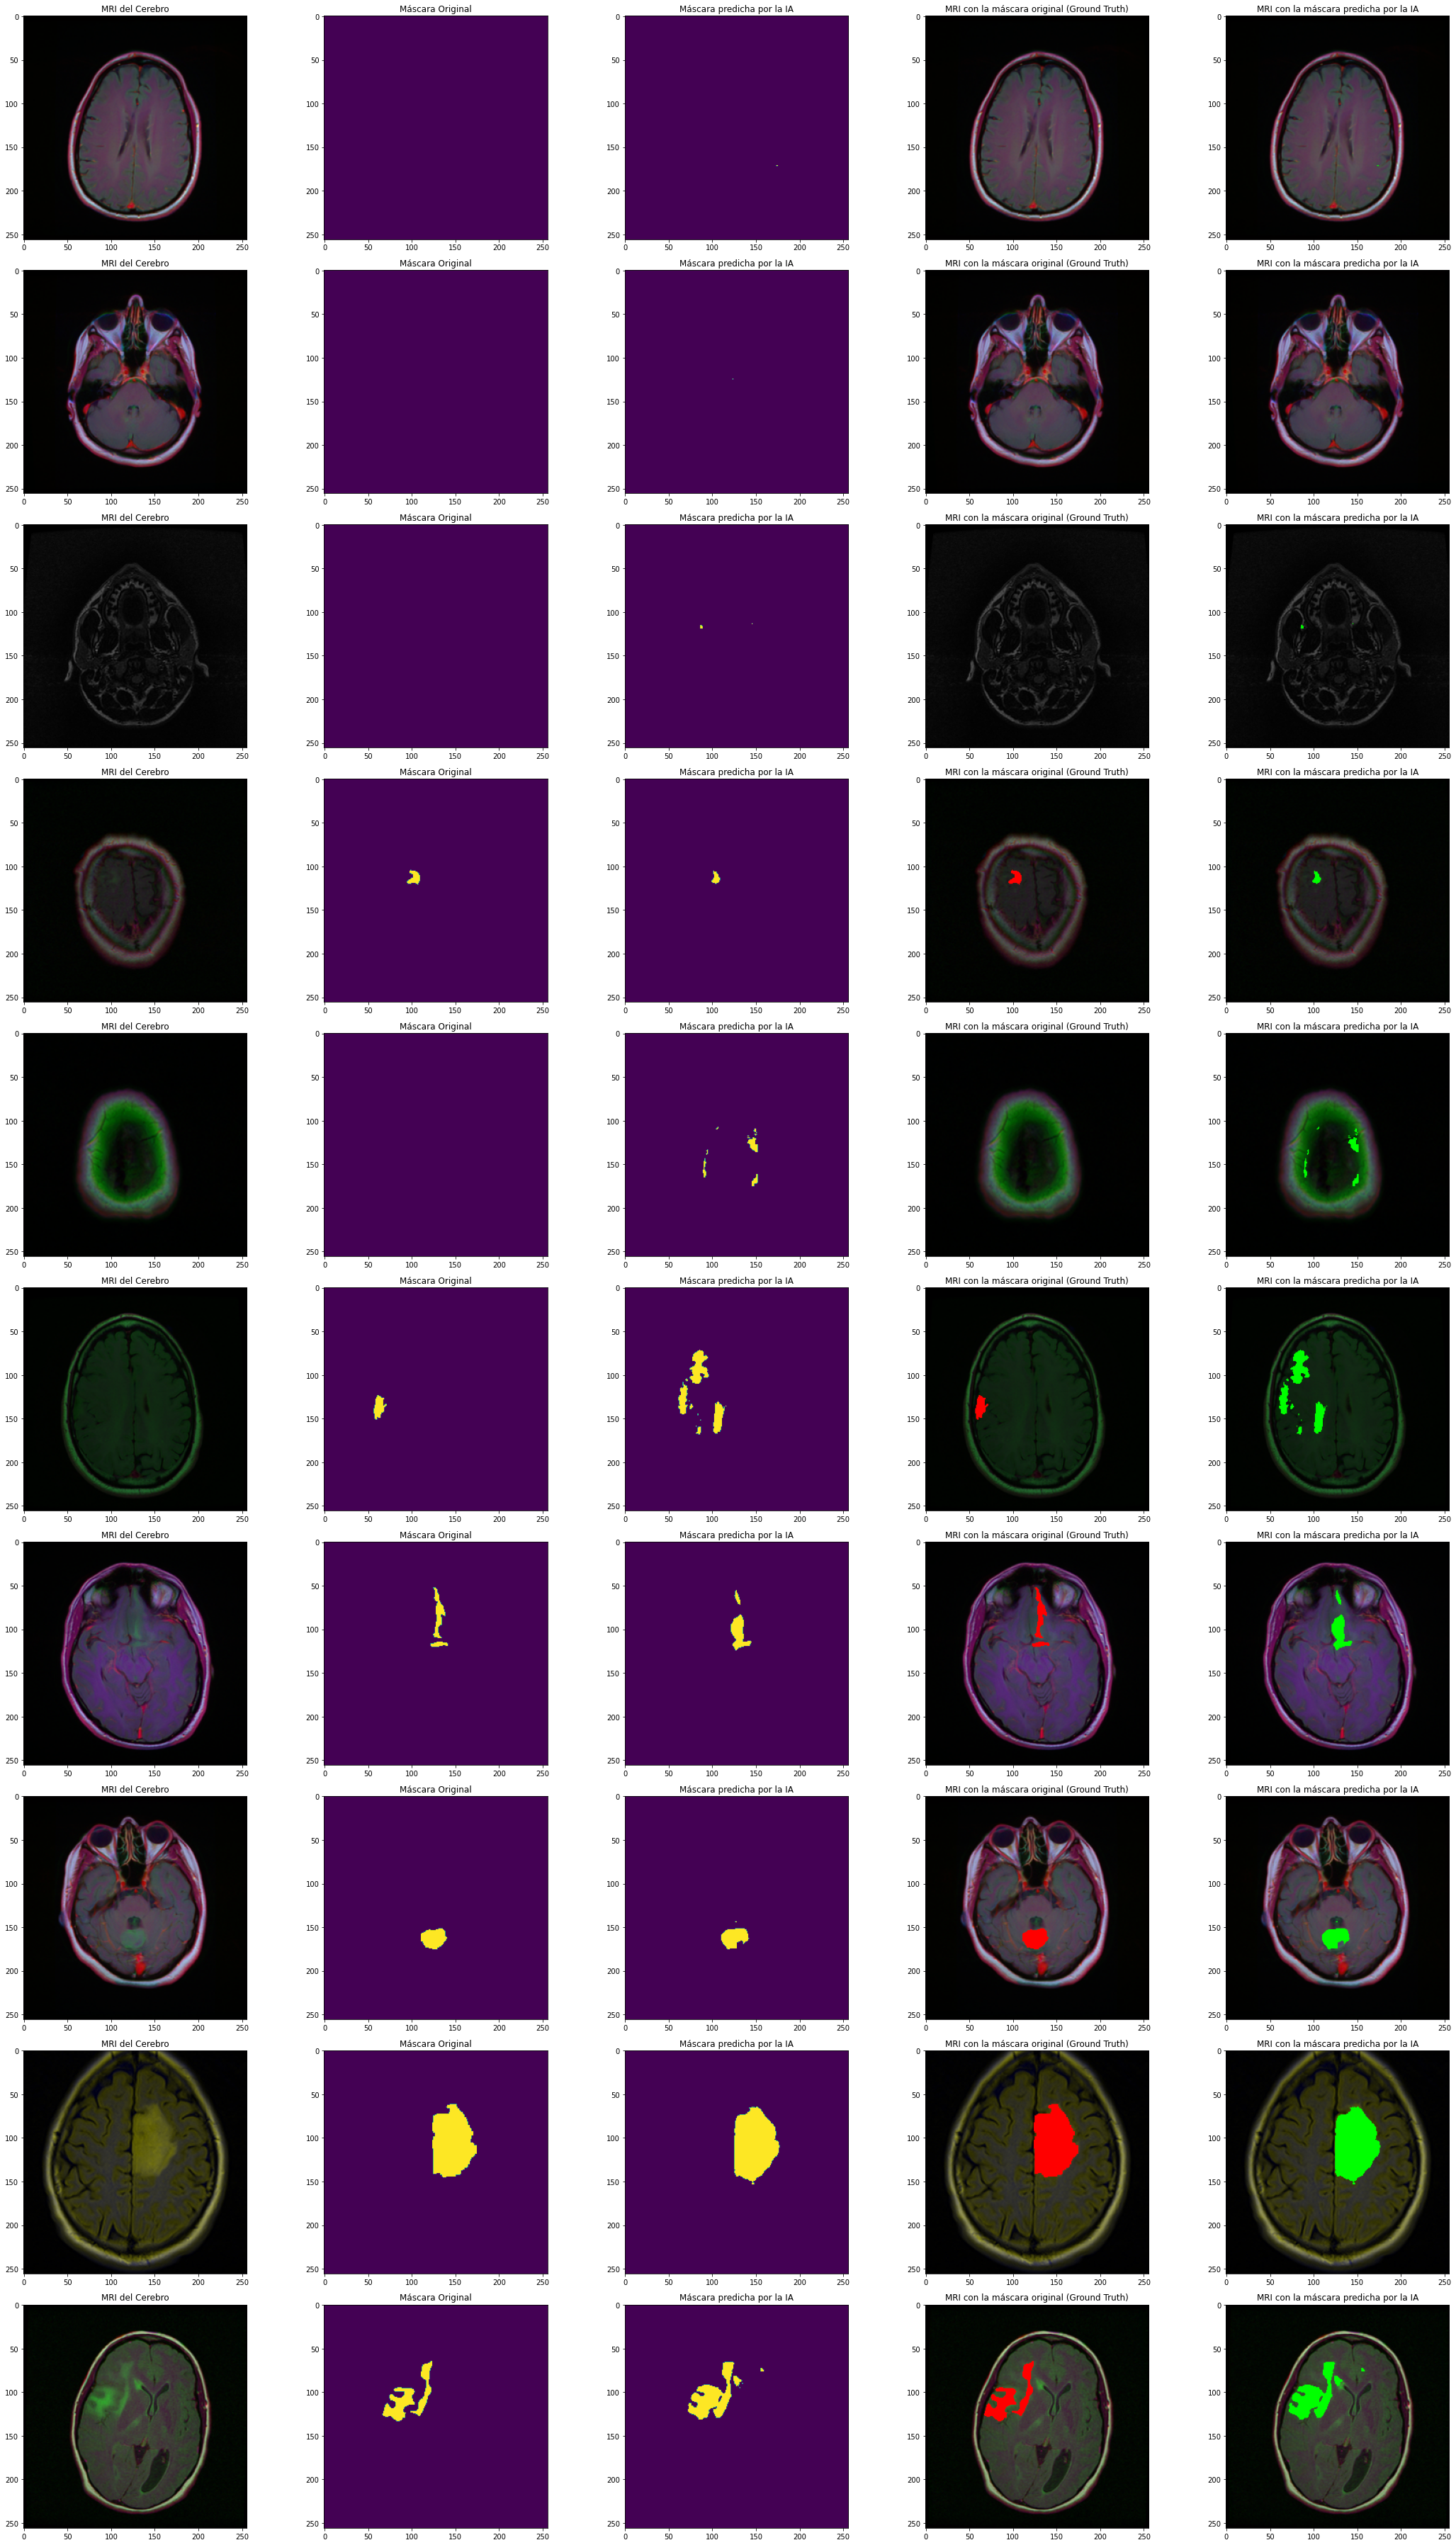

In [173]:
count = 0 

fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):

    if df_pred['has_mask'][i] == 1 and count < 10:
        # leer las imágenes y convertirlas a formato RGB
        img = io.imread(df_pred.image_path[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[count][0].title.set_text("MRI del Cerebro")
        axs[count][0].imshow(img)

        # Obtenemos la máscara para la imagen
        mask = io.imread(df_pred.mask_path[i])
        axs[count][1].title.set_text("Máscara Original")
        axs[count][1].imshow(mask)

        # Obtenemos la máscara de predicción para dicha imagen
        predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
        axs[count][2].title.set_text("Máscara predicha por la IA")
        axs[count][2].imshow(predicted_mask)
        
        # Aplicamos la máscara a la imagen 'mask==255'
        img[mask == 255] = (255, 0, 0)
        axs[count][3].title.set_text("MRI con la máscara original (Ground Truth)")
        axs[count][3].imshow(img)

        img_ = io.imread(df_pred.image_path[i])
        img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
        img_[predicted_mask == 1] = (0, 255, 0)
        axs[count][4].title.set_text("MRI con la máscara predicha por la IA")
        axs[count][4].imshow(img_)
        count += 1

fig.tight_layout()